# Predicting Multiple Time Series data at once (Multi-Variate Time Series)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

from tensorflow.contrib import learn
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from lstm import lstm_model
from data_processing import load_csvdata

# Energy building data from the UCI repository

In [2]:
energy = pd.read_csv('data/energydata_complete.csv')
energy =energy[['RH_1','RH_2','RH_3','RH_4','RH_5','RH_6']]
# https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction

In [3]:
energy.head()

,RH_1,RH_2,RH_3,RH_4,RH_5,RH_6
0,47.596667,44.790000,44.730000,45.566667,55.20,84.256667
1,46.693333,44.722500,44.790000,45.992500,55.20,84.063333
2,46.300000,44.626667,44.933333,45.890000,55.09,83.156667
3,46.066667,44.590000,45.000000,45.723333,55.09,83.423333
4,46.333333,44.530000,45.000000,45.530000,55.09,84.893333


In [4]:
# adding noise to the data before having LSTM predict on it
energy_noise = energy.apply(lambda x: np.random.normal(loc=0.0, scale=2)+ x, axis = 1)
# axis 1 does it column wise, or else it won't have the same affect
# More on np.random.normal:
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html

In [5]:
energy_noise.head()

,RH_1,RH_2,RH_3,RH_4,RH_5,RH_6
0,47.981905,45.175238,45.115238,45.951905,55.585238,84.641905
1,46.796634,44.825801,44.893301,46.095801,55.303301,84.166634
2,48.353923,46.680589,46.987256,47.943923,57.143923,85.210589
3,46.549521,45.072854,45.482854,46.206188,55.572854,83.906188
4,49.241005,47.437672,47.907672,48.437672,57.997672,87.801005


# Scaling Data

In [7]:
min_max_scaler = preprocessing.MinMaxScaler()
energy_scaled = min_max_scaler.fit_transform(energy)
RH_scaled = min_max_scaler.fit_transform(energy_noise)

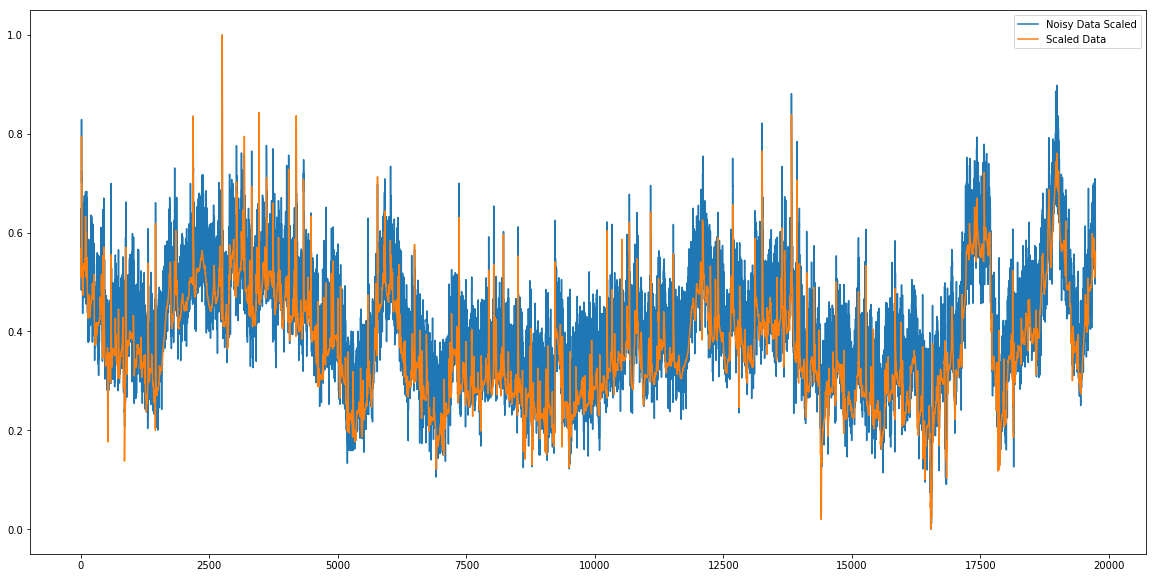

In [12]:
plt.figure(figsize=(20,10))
plt.plot(RH_scaled[:,0], label='Noisy Data Scaled')
plt.plot(energy_scaled[:,0],label="Scaled Data")
plt.legend()

# Setting parameters

In [13]:
LOG_DIR = './ops_logs/RH_Noise'
TIMESTEPS = 20
RNN_LAYERS = [{'num_units': 10}, {'num_units': 2}]
DENSE_LAYERS = None
TRAINING_STEPS = 20000
PRINT_STEPS = TRAINING_STEPS / 10
BATCH_SIZE = 2000

# Fitting Model

In [14]:
regressor = learn.SKCompat(learn.Estimator(
    model_fn=lstm_model(
        TIMESTEPS,
        RNN_LAYERS,
        DENSE_LAYERS
    ),
    model_dir=LOG_DIR
))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c1dc09550>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': './ops_logs/RH_Noise'}


In [15]:
X, y = load_csvdata(RH_scaled, TIMESTEPS, seperate=False)
# create a lstm instance and validation monitor
validation_monitor = learn.monitors.ValidationMonitor(X['val'], y['val'],
                                                      every_n_steps=PRINT_STEPS,
                                                      early_stopping_rounds=1000)
regressor.fit(X['train'], y['train'], 
              monitors=[validation_monitor], 
              batch_size=BATCH_SIZE,
              steps=TRAINING_STEPS)

Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
Instructions for updating:
Use `tf.contrib.losses.mean_squared_error` and explicit logits computation.
Instructions for updating:
Use tf.losses.mean_squared_error instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./ops_logs/RH_Noise/model.ckpt.
INFO:tensorflow:loss = 0.20721, step = 1
INFO:tensorflow:global_step/sec: 8.64098
INFO:tensorflow:loss = 0.195636, step = 101 (11.574 sec)
INFO:tensorflow:global_step/sec: 8.86123
INFO:tensorflow:loss = 0.183143, step = 201 (11.285 sec)
INFO:tensorflow:global_step/sec: 8.896
INFO:tensorflow:loss = 0.177634, step = 301 (11.242 sec)
INFO:tensorflow:global_step/sec: 9.27671
INFO:tensorflow:loss = 0.171284, step = 401 (10.779 sec)
INFO:tensorflow:global_step/sec: 9.00026
INFO:tensorflow

INFO:tensorflow:global_step/sec: 10.1427
INFO:tensorflow:loss = 0.0227808, step = 3601 (9.859 sec)
INFO:tensorflow:global_step/sec: 10.2139
INFO:tensorflow:loss = 0.0222871, step = 3701 (9.791 sec)
INFO:tensorflow:global_step/sec: 10.1497
INFO:tensorflow:loss = 0.0214894, step = 3801 (9.852 sec)
INFO:tensorflow:global_step/sec: 10.1291
INFO:tensorflow:loss = 0.0222502, step = 3901 (9.873 sec)
INFO:tensorflow:global_step/sec: 10.1387
INFO:tensorflow:loss = 0.0210332, step = 4001 (9.863 sec)
INFO:tensorflow:global_step/sec: 10.1061
INFO:tensorflow:loss = 0.0208579, step = 4101 (9.895 sec)
INFO:tensorflow:global_step/sec: 10.0934
INFO:tensorflow:loss = 0.0210764, step = 4201 (9.908 sec)
INFO:tensorflow:global_step/sec: 10.1012
INFO:tensorflow:loss = 0.0215567, step = 4301 (9.900 sec)
INFO:tensorflow:global_step/sec: 10.1473
INFO:tensorflow:loss = 0.0203359, step = 4401 (9.855 sec)
INFO:tensorflow:global_step/sec: 10.111
INFO:tensorflow:loss = 0.0201685, step = 4501 (9.890 sec)
INFO:tensor

INFO:tensorflow:global_step/sec: 10.1543
INFO:tensorflow:loss = 0.0170565, step = 8901 (9.848 sec)
INFO:tensorflow:global_step/sec: 10.153
INFO:tensorflow:loss = 0.0169733, step = 9001 (9.850 sec)
INFO:tensorflow:global_step/sec: 10.1367
INFO:tensorflow:loss = 0.0163634, step = 9101 (9.865 sec)
INFO:tensorflow:global_step/sec: 10.1913
INFO:tensorflow:loss = 0.0164572, step = 9201 (9.812 sec)
INFO:tensorflow:global_step/sec: 10.0948
INFO:tensorflow:loss = 0.0160556, step = 9301 (9.906 sec)
INFO:tensorflow:global_step/sec: 10.1543
INFO:tensorflow:loss = 0.016097, step = 9401 (9.848 sec)
INFO:tensorflow:global_step/sec: 9.98907
INFO:tensorflow:loss = 0.0164205, step = 9501 (10.011 sec)
INFO:tensorflow:global_step/sec: 10.0701
INFO:tensorflow:loss = 0.0160828, step = 9601 (9.930 sec)
INFO:tensorflow:global_step/sec: 10.1277
INFO:tensorflow:loss = 0.0162092, step = 9701 (9.874 sec)
INFO:tensorflow:global_step/sec: 10.0949
INFO:tensorflow:loss = 0.0160151, step = 9801 (9.906 sec)
INFO:tensor

INFO:tensorflow:loss = 0.00668749, step = 14101 (10.376 sec)
INFO:tensorflow:global_step/sec: 7.9707
INFO:tensorflow:loss = 0.00663105, step = 14201 (12.545 sec)
INFO:tensorflow:global_step/sec: 9.24165
INFO:tensorflow:loss = 0.00649802, step = 14301 (10.821 sec)
INFO:tensorflow:global_step/sec: 9.17681
INFO:tensorflow:loss = 0.00668621, step = 14401 (10.897 sec)
INFO:tensorflow:global_step/sec: 9.93918
INFO:tensorflow:loss = 0.00650248, step = 14501 (10.061 sec)
INFO:tensorflow:global_step/sec: 9.37798
INFO:tensorflow:loss = 0.00642885, step = 14601 (10.663 sec)
INFO:tensorflow:global_step/sec: 10.0109
INFO:tensorflow:loss = 0.0064177, step = 14701 (9.989 sec)
INFO:tensorflow:global_step/sec: 9.94157
INFO:tensorflow:loss = 0.00631439, step = 14801 (10.059 sec)
INFO:tensorflow:global_step/sec: 9.89289
INFO:tensorflow:loss = 0.00636314, step = 14901 (10.108 sec)
INFO:tensorflow:global_step/sec: 9.93321
INFO:tensorflow:loss = 0.0063278, step = 15001 (10.067 sec)
INFO:tensorflow:global_st

INFO:tensorflow:global_step/sec: 9.72041
INFO:tensorflow:loss = 0.00611065, step = 19301 (10.288 sec)
INFO:tensorflow:global_step/sec: 9.95071
INFO:tensorflow:loss = 0.00605992, step = 19401 (10.050 sec)
INFO:tensorflow:global_step/sec: 10.001
INFO:tensorflow:loss = 0.00596198, step = 19501 (9.999 sec)
INFO:tensorflow:global_step/sec: 9.96489
INFO:tensorflow:loss = 0.00594303, step = 19601 (10.035 sec)
INFO:tensorflow:global_step/sec: 9.98772
INFO:tensorflow:loss = 0.00595265, step = 19701 (10.012 sec)
INFO:tensorflow:global_step/sec: 9.94811
INFO:tensorflow:loss = 0.00626105, step = 19801 (10.052 sec)
INFO:tensorflow:global_step/sec: 9.9072
INFO:tensorflow:loss = 0.00615641, step = 19901 (10.094 sec)
INFO:tensorflow:Saving checkpoints for 20000 into ./ops_logs/RH_Noise/model.ckpt.
INFO:tensorflow:Loss for final step: 0.00610613.


SKCompat()

# MSE between predicted and Actual

In [16]:
predicted = regressor.predict(X['test'])
rmse = np.sqrt(((predicted - y['test']) ** 2).mean(axis=0))
score = mean_squared_error(predicted, y['test'])
print ("MSE: %f" % score)
print ("RMSE: %f" % score)
# since I am training multiple time series data, I need a really small MSE, such as .001 or less
# some predictions fit better than others

Instructions for updating:
Use `tf.contrib.losses.mean_squared_error` and explicit logits computation.
Instructions for updating:
Use tf.losses.mean_squared_error instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
INFO:tensorflow:Restoring parameters from ./ops_logs/RH_Noise/model.ckpt-20000
MSE: 0.006452
RMSE: 0.006452


# Plotting all Data

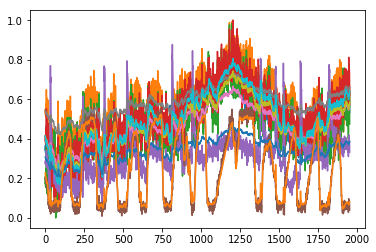

In [17]:
plt.plot(y['test'])
plt.plot(predicted)

# Looking at individual time series data

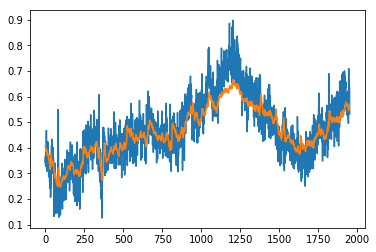

In [18]:
plt.plot(y['test'][:,0])
plt.plot(predicted[:,0])

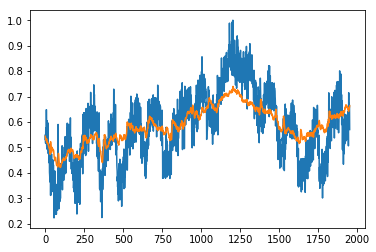

In [19]:
plt.plot(y['test'][:,1])
plt.plot(predicted[:,1])

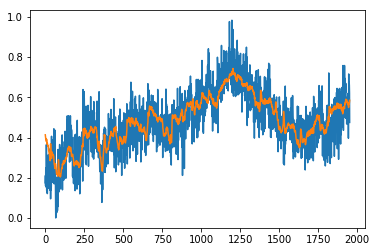

In [20]:
plt.plot(y['test'][:,2])
plt.plot(predicted[:,2])

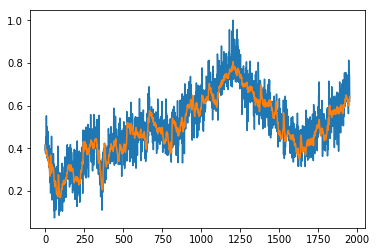

In [21]:
plt.plot(y['test'][:,3])
plt.plot(predicted[:,3])

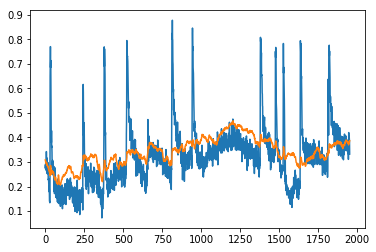

In [22]:
plt.plot(y['test'][:,4])
plt.plot(predicted[:,4])

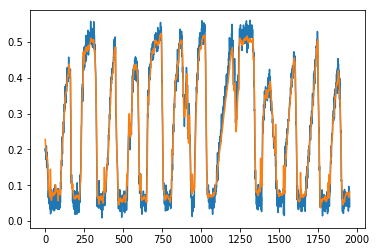

In [23]:
plt.plot(y['test'][:,5])
plt.plot(predicted[:,5])